<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/Completed_DAE_with_PSNR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.optim as optim
from tqdm import tqdm
import skimage.util.noise as noise 
import math

In [2]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 5000개, 10000개, 10000개
tr_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()) 
tr_subset, val_subset = torch.utils.data.random_split(tr_dataset, [50000,10000], generator=torch.Generator().manual_seed(1))
test_set  = torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=transforms.ToTensor())

num_workers= 2
batch_size = 256

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
X_train_set = tr_subset.dataset.data[tr_subset.indices]
Y_train_set = tr_subset.dataset.targets[tr_subset.indices]
X_val_set = val_subset.dataset.data[val_subset.indices]
Y_val_set = val_subset.dataset.targets[val_subset.indices]

train_loader = torch.utils.data.DataLoader(tr_subset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

In [4]:
print(len(train_loader)) # 1epoch당 196개의 minibatch(iteration) update 진행
print(len(valid_loader)) #1epoch당 1epoch당 40개의 미니배치로 val_loss를 측정함. update X

196
40


In [5]:
train_set_arr = X_train_set.numpy() #numpy 자료형(ndarray) 변환
val_set_arr = X_val_set.numpy()

# PNSR function

In [29]:
def get_psnr(input, output, max_val=1):

    input = input.cpu().detach().numpy()
    output = output.cpu().detach().numpy()
    img_diff = output - input
    rmse = np.mean(img_diff**2)
    
    if rmse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/rmse)
      return psnr 

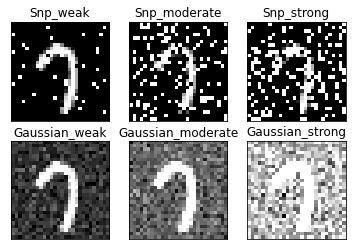

In [30]:
#numpy

Snp_weak_train_arr = noise.random_noise(train_set_arr,mode='s&p',amount=0.1) 
Snp_moderate_train_arr = noise.random_noise(train_set_arr,mode='s&p',amount=0.3)
Snp_strong_train_arr = noise.random_noise(train_set_arr,mode='s&p',amount=0.5)

Snp_weak_val_arr = noise.random_noise(val_set_arr,mode='s&p',amount=0.1) 
Snp_moderate_val_arr = noise.random_noise(val_set_arr,mode='s&p',amount=0.3)
Snp_strong_val_arr = noise.random_noise(val_set_arr,mode='s&p',amount=0.5)

Gn_weak_train_arr = noise.random_noise(train_set_arr,mode='gaussian',mean=0.2) 
Gn_moderate_train_arr = noise.random_noise(train_set_arr,mode='gaussian',mean=0.5)
Gn_strong_train_arr = noise.random_noise(train_set_arr,mode='gaussian',mean=0.9)

Gn_weak_val_arr = noise.random_noise(val_set_arr,mode='gaussian',mean=0.2) 
Gn_moderate_val_arr = noise.random_noise(val_set_arr,mode='gaussian',mean=0.5)
Gn_strong_val_arr = noise.random_noise(val_set_arr,mode='gaussian',mean=0.9)



titles = ['Snp_weak', 'Snp_moderate', 'Snp_strong', 'Gaussian_weak', 
          'Gaussian_moderate', 'Gaussian_strong']

images = [ Snp_weak_train_arr[0], Snp_moderate_train_arr[0], Snp_strong_train_arr[0],
          Gn_weak_train_arr[0], Gn_moderate_train_arr[0], Gn_strong_train_arr[0]]

for i in range(6):
  plt.subplot(2,3,i+1), plt.imshow(images[i],cmap='gray')
  plt.title(titles[i])
  plt.xticks([]), plt.yticks([]) 


In [31]:
Snp_weak_train = torch.from_numpy(Snp_weak_train_arr).float().div(255.0).unsqueeze(1)
Snp_weak_val = torch.from_numpy(Snp_weak_val_arr).float().div(255.0).unsqueeze(1)

Snp_moderate_train = torch.from_numpy(Snp_moderate_train_arr).float().div(255.0).unsqueeze(1)
Snp_moderate_val = torch.from_numpy(Snp_moderate_val_arr).float().div(255.0).unsqueeze(1)

Snp_strong_train= torch.from_numpy(Snp_strong_train_arr).float().div(255.0).unsqueeze(1)
Snp_strong_val = torch.from_numpy(Snp_strong_val_arr).float().div(255.0).unsqueeze(1)

Gn_weak_train = torch.from_numpy(Gn_weak_train_arr).float().div(255.0).unsqueeze(1)
Gn_weak_val = torch.from_numpy(Gn_weak_val_arr).float().div(255.0).unsqueeze(1)

Gn_moderate_train = torch.from_numpy(Gn_moderate_train_arr).float().div(255.0).unsqueeze(1)
Gn_moderate_val = torch.from_numpy(Gn_moderate_val_arr).float().div(255.0).unsqueeze(1)

Gn_strong_train = torch.from_numpy(Gn_strong_train_arr).float().div(255.0).unsqueeze(1)
Gn_strong_val = torch.from_numpy(Gn_strong_val_arr).float().div(255.0).unsqueeze(1)


Snp_weak_train_loader = DataLoader(Snp_weak_train,batch_size=batch_size)
Snp_weak_val_loader = DataLoader(Snp_weak_val,batch_size=batch_size)

Snp_moderate_train_loader = DataLoader(Snp_moderate_train,batch_size=batch_size)
Snp_moderate_val_loader = DataLoader(Snp_moderate_val,batch_size=batch_size)

Snp_strong_train_loader = DataLoader(Snp_strong_train,batch_size=batch_size)
Snp_strong_val_loader = DataLoader(Snp_strong_val,batch_size=batch_size)



In [32]:
Custom_Snp_weak_train = []
for i in range(len(Snp_weak_train)):
  Custom_Snp_weak_train.append([Snp_weak_train[i],Y_train_set[i]])

  
Custom_snp_weak_train_loader = DataLoader(Custom_Snp_weak_train,batch_size=batch_size)

Custom_Snp_weak_val = []
for i in range(len(Snp_weak_val)):
  Custom_Snp_weak_val.append([Snp_weak_val[i],Y_val_set[i]])
  
Custom_snp_weak_val_loader = DataLoader(Custom_Snp_weak_val,batch_size=batch_size)

In [33]:
class Encoder(nn.Module):   

  def __init__(self, encoded_space_dim,fc2_input_dim): 
    super().__init__()

    self.encoder_cnn = nn.Sequential( 
        
        #1, 28, 28 
        nn.Conv2d(in_channels = 1,out_channels = 8,kernel_size = 3, stride = 2, padding = 1),
        #8, 14, 14               #https://machine-geon.tistory.com/46
        nn.ReLU(True), 

         
        nn.Conv2d(in_channels = 8,out_channels = 16,kernel_size = 3, stride=2, padding = 1), 
        #16, 7, 7
        nn.BatchNorm2d(16), 
        nn.ReLU(True),
        
        nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = 3, stride=2, padding=0),
        #32, 3, 3
        nn.ReLU(True)
    )

    self.flatten = nn.Flatten(start_dim=1) 
    # 32 X 3 X 3 -> 288

    self.encoder_lin = nn.Sequential( 
        nn.Linear(3*3*32,fc2_input_dim), #288 -> 128
        nn.ReLU(True),
        nn.Linear(fc2_input_dim, encoded_space_dim) #128->4 
    )

  def forward(self, x): #출력
    x = self.encoder_cnn(x) 
    x = self.flatten(x)
    x = self.encoder_lin(x)
    return x

In [34]:
class Decoder(nn.Module): 
                          
  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__() 
    self.decoder_lin = nn.Sequential( 
        nn.Linear(encoded_space_dim, fc2_input_dim), #4 -> 128
        nn.ReLU(True),
        nn.Linear(fc2_input_dim, 3*3*32), #128 -> 256 
        nn.ReLU(True)
    )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32,3,3))
     # 256 -> 32,3,3    
    self.decoder_conv = nn.Sequential(  
        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3,
        stride=2, output_padding=0),
         #16,7,7 
        nn.BatchNorm2d(16),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size=3, 
       stride= 2, padding=1, output_padding=1), 
       #8, 14, 14
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels = 8, out_channels =1,  kernel_size = 3,
        stride=2, padding=1, output_padding=1)  
        #1, 28, 28
    )
     
  def forward(self, x): 
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x) #마지막에 sigmoid를 넣어서 원래의 이미지로 복원한다.
    return x  

In [35]:
lr = 0.001
torch.manual_seed(0) #manual_seed로 랜덤 난수를 고정함.
d=4

encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128) #처음에 4차원으로 세팅함. 32,1,28,28로 입력값으로 입력시킬 예정이다. [batch,channel.height,width] 
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128) 

In [36]:
loss_fn = torch.nn.MSELoss()

params_to_optimize = [ 
  {'params' : encoder.parameters()},  #모델마다 각각의 learning_rate를 설정 
  {'params' : decoder.parameters()}   
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
print('Selected device : {%s}' % device)

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05) 
#weight_decay는 overfitiing 방지 용도임. 최적화 할 때 L2 penalty를 부여해서 loss를 최소화 한다.(Lasso 정규화 참고) 

encoder.to(device) 
decoder.to(device) 

Selected device : {cpu}


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [43]:
def AE_train_epoch_den(encoder,decoder, device, dataloader,dataloader_hat,loss_fn, optimizer):
  encoder.train() 
  decoder.train()
  train_loss = [] 
  
  for i,(origin,noisy) in enumerate(zip(dataloader,dataloader_hat)):
    origin_img,_ = origin 
    corrupted_img,_ = noisy

    origin_img = origin_img.to(device)
    corrupted_img=corrupted_img.to(device)

    encoded_data = encoder(corrupted_img)
    decoded_data = decoder(encoded_data)
    loss = loss_fn(decoded_data, origin_img)

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    # 현재 epoch에서의 손실율을 반환한다.
    # loss는 GPU상의 tensor. detach로 그래프(역전파 계산이 끝난 연산기록)에서 분리한 tensor 반환
    # (loss에서 따온)GPU메모리에 올려져 있는 tensor를 cpu 메모리에 복사
    # tesnor를 numpy로 변환시키기 위해서는 cpu 메모리에 존재해야 하므로 .순서상 cpu()>.numpy()이다.
    # (cpu에 복사된)tensor를 numpy로 변환해서 반환 시킨다.(cpu tensor와 numpy array는 저장공간을 공유하는 장점. Gpu tensor는 공유 하지 않음)
    
                                                            
                                                            
  return np.mean(train_loss)


In [38]:
def AE_test_epoch_den(encoder, decoder, device, dataloader,dataloader_hat,loss_fn):
    encoder.eval() #train 하지 않고 대신에 evaluation mode사용. 테스트 데이터만 가지고 비교 할 것이기 때문임
    decoder.eval() 
    with torch.no_grad(): #with을 써서 gradient 계산을 막아준다.(required_grad=False와 같음). 학습을 하지 않기 때문에 no.grad()일 수 있다.
      conc_out = [] #리스트 자료형 가져옴 
      conc_label = []
      for i,(origin,noisy) in enumerate(zip(dataloader,dataloader_hat)):
        origin_img,_ = origin 
        corrupted_img,_ = noisy
        origin_img = origin_img.to(device)
        corrupted_img=corrupted_img.to(device)    
      
        encoded_data = encoder(corrupted_img)
        decoded_data = decoder(encoded_data)
        
        conc_out.append(decoded_data.cpu()) #decoded_data를 cpu 메모리에 복사하고 이 값을 conc_out 변수에 객체를 추가한다. 
        conc_label.append(origin_img.cpu())  #원본이미지를 conc_label에 추가시켜준다. 쿠다에서 복사해온다.
                                              #문자열 추가함수 append이다. 텐서의 차원을 추가하려면 cat을 쓴다.

      conc_out = torch.cat(conc_out) #concatenate(텐서를 결합하는 함수)다. 반환은 당연히 텐서다. 차원증가와 함께 실제 값이 추가 된다. dim=0이 default이다.
      conc_label = torch.cat(conc_label)

      val_loss = loss_fn(conc_out, conc_label) # loss 비교는 원본이미지 
    return val_loss.data #val_loss반환값이 test_epoch_den 함수인지 아니면 torch.no_grad()함수인지 모르겠다

In [39]:
def plot_ae_outputs_den(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_set.targets.numpy() 
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):
    
      ax = plt.subplot(3, n, i+1)
      img = test_set[t_idx[i]][0].unsqueeze(0)     
      Noisy_image_arr = noise.random_noise(img,mode='s&p',amount=0.1)
      Noisy_image = torch.from_numpy(Noisy_image_arr).float().div(255.0)
      torch.reshape(Noisy_image, (1,28,28))
      Noisy_image = Noisy_image.to(device)
      img = img.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(Noisy_image))
      
      PSNR = get_psnr(img, rec_img, max_val = 1.)
      print(PSNR,'\n')

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(Noisy_image.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2: # 나누기 후 소수점 부분을 버린다.
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()

In [40]:
##Training Cycle
num_epochs = 25
history_da = {'train_loss':[], 'val_loss':[]}
print(history_da)

{'train_loss': [], 'val_loss': []}


EPOCH 1/25


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 EPOCH 1/25 	 train loss nan 	 val loss 0.029
15.592592788567023 

23.060341293349644 

15.36790907058123 

14.997681184362865 

16.691639523231995 

9.933729460193645 

13.22709929669684 

18.96240172908729 

12.060096735912696 

14.366608194862753 



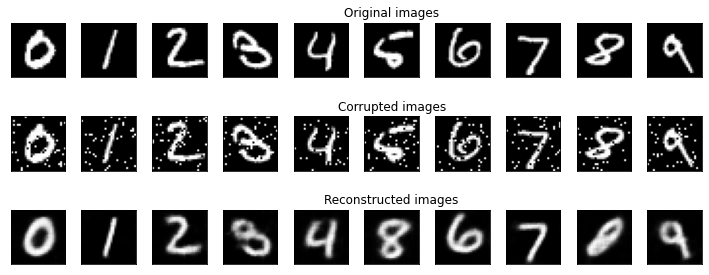

EPOCH 2/25
EPOCH 3/25
EPOCH 4/25
EPOCH 5/25
EPOCH 6/25

 EPOCH 6/25 	 train loss nan 	 val loss 0.031
15.054631820174471 

22.948266986914774 

14.698096539863572 

14.004022692748592 

16.018808262025 

10.958394619503604 

13.667751819504229 

16.01211753997632 

12.300127629022429 

14.35744780363326 



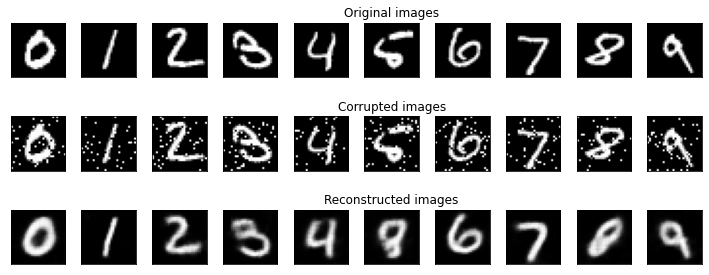

EPOCH 7/25
EPOCH 8/25
EPOCH 9/25
EPOCH 10/25
EPOCH 11/25

 EPOCH 11/25 	 train loss nan 	 val loss 0.029
15.315777479707808 

24.782706143244624 

15.68334596033992 

13.655615512775384 

17.017383436059248 

10.269760273726254 

14.516100038085305 

18.86270624030881 

12.130222379124119 

14.758792213811196 



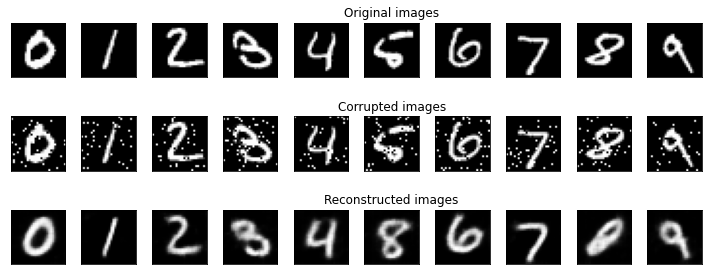

EPOCH 12/25
EPOCH 13/25
EPOCH 14/25
EPOCH 15/25
EPOCH 16/25

 EPOCH 16/25 	 train loss nan 	 val loss 0.028
15.320760215489372 

24.31599831083784 

15.931395435080377 

14.156708616150928 

16.910926715267426 

10.270739948012741 

15.825204912349097 

18.75560643590515 

12.240737666224256 

14.753359113422961 



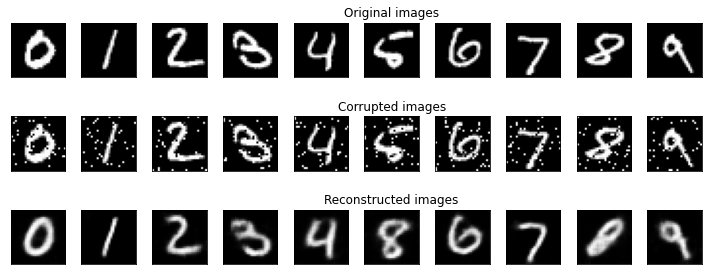

EPOCH 17/25
EPOCH 18/25
EPOCH 19/25
EPOCH 20/25
EPOCH 21/25

 EPOCH 21/25 	 train loss nan 	 val loss 0.029
15.43896245659322 

23.249989278835077 

15.282337079410564 

13.79816595343032 

16.59979064325253 

10.532728624654409 

15.796886491753188 

19.188343517715857 

12.072646816588504 

14.525269102092025 



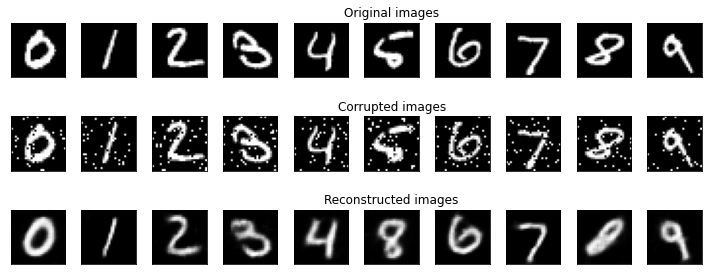

EPOCH 22/25
EPOCH 23/25
EPOCH 24/25
EPOCH 25/25


In [44]:
for epoch in range(num_epochs): 
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=AE_train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device,
        dataloader=train_loader, 
        dataloader_hat=Custom_snp_weak_train_loader,
        loss_fn=loss_fn, 
        optimizer=optim)


# Validation ach 5 epochs     
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    
    if ((epoch+1)% 5) == 0 :
        val_loss = AE_test_epoch_den( 
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        dataloader_hat=Custom_snp_weak_val_loader,
        loss_fn=loss_fn) 
    
    # validation loss, not test loss 

        
        print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
        plot_ae_outputs_den(encoder, decoder)        


In [ ]:
#After training
AE_test_epoch_den(encoder, decoder, device, dataloader,dataloader_hat, loss_fn).item()

In [ ]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()